# CSE 252B: Computer Vision II, Winter 2018 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 7, 2018, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Programing): Feature Detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

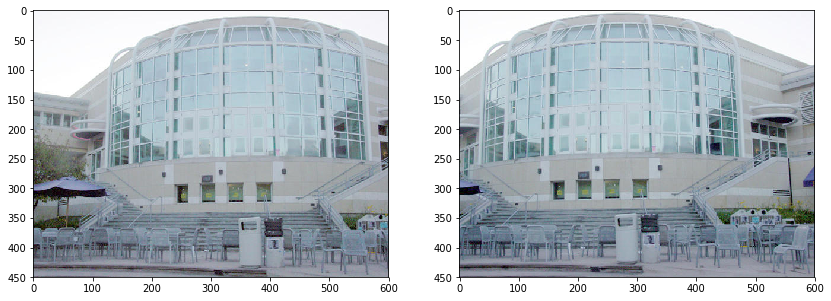

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

450 600
450 600


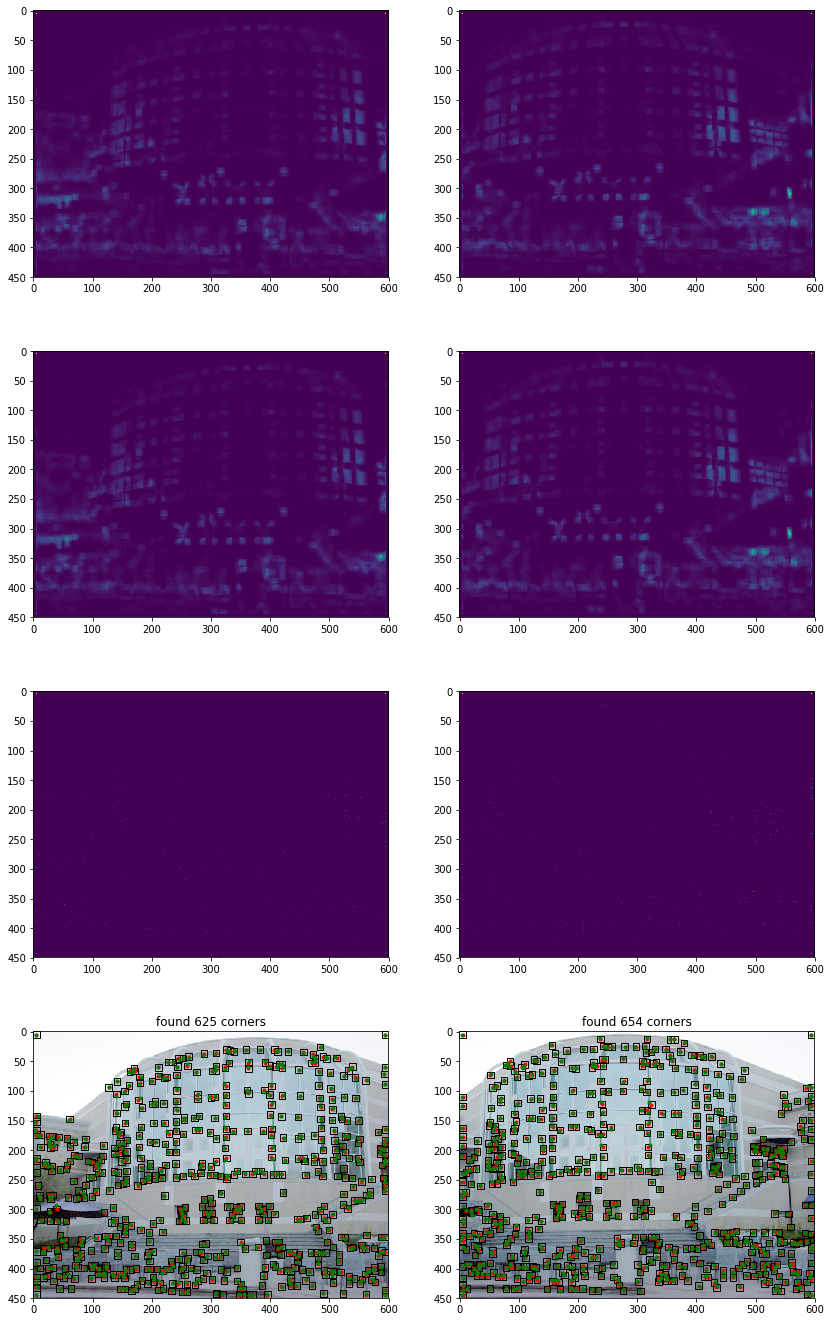

In [19]:
def corner(I, w, t, w_nms):
    # inputs: 
    # I is the input image (may be mxn for BW or mxnx3 for RGB)
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the window used for nonmaximal supression
    # outputs:
    # J0 is the mxn image of minor eigenvalues of N before thresholding
    # J1 is the mxn image of minor eigenvalues of N after thresholding
    # J2 is the mxn image of minor eigenvalues of N after nonmaximal supression
    # pts0 is the 2xk list of coordinates of (pixel accurate) corners
    #     (ie. coordinates of nonzero values of J2)
    # pts1 is the 2xk list of coordinates of subpixel accurate corners
    #     found using the Forstner detector
    
    """your code here"""   
    if len(I.shape) == 3:
        r,g,b = I[:,:,0], I[:,:,1], I[:,:,2]
        I = 0.2989 * r + 0.5807 * g + 0.1140 * b
    m,n = I.shape[:2]
    
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
    J2 = np.zeros((m,n))
    
    w_2 = (w - 1) // 2
    w_num_2 = (w_nms - 1) // 2
    
    thres = t
    kx = np.array([-1,8,0,-8,1]) / 12
    
    Ix0 = np.zeros((m, n))
    Iy0 = np.zeros((n, m))
    
    I1 = I.T

    
    for i in range(m):
        Ix0[i] = np.convolve(kx, I[i], 'same')
    for i in range(n):
        Iy0[i] = np.convolve(kx, I1[i], 'same')
        
    Iy0 = Iy0.T
    
    IxIx=np.multiply(Ix0,Ix0)
    IxIy=np.multiply(Ix0,Iy0)
    IyIx=np.multiply(Iy0,Ix0)
    IyIy=np.multiply(Iy0,Iy0)
    N=np.zeros((2,2))


    pts0 = np.zeros((2, 1), dtype = int)
    pts1 = np.zeros((2, 1), dtype = int)
    
    N2=np.zeros((2,1))
    
    for i in range(w_2, m - w_2):
        for j in range(w_2, n - w_2):
            N[0][0]=np.sum(IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
            N[0][1]=np.sum(IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
            N[1][0]=np.sum(IyIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
            N[1][1]=np.sum(IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
    
            lbd_l=(np.trace(N)-abs(np.trace(N)**2-4*np.linalg.det(N))**0.5)/2
    
            J0[i][j]=lbd_l
        
    J1=np.multiply(J0>thres,J0)    
    
    for i in range(w_num_2,m-w_num_2):
        for j in range(w_num_2,n-w_num_2):
            J2[i][j]=(J1[i][j] == np.max(J1[i-w_num_2:i+w_num_2+1,\
                            j-w_num_2:j+w_num_2+1]))*J1[i][j]

    for i in range(m):
        for j in range(n):
            if J2[i][j]>0:
                pts0 = np.hstack((pts0, np.array([[i],[j]])))
    pts0 = np.delete(pts0,0,1)

    for k in range(pts0.shape[1]):
        i = pts0[0,k]
        j = pts0[1,k]
        
        x_temp=np.dot(np.ones((w,1)),np.array([range(i-w_2,i+w_2+1)]))
        y_temp=np.dot(np.ones((w,1)),np.array([range(j-w_2,j+w_2+1)]))
        x_temp=x_temp.transpose()

        N[0][0]=np.sum(IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])
        N[0][1]=np.sum(IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])
        N[1][0]=np.sum(IyIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])
        N[1][1]=np.sum(IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])

        N2[0]=np.sum(np.multiply(x_temp,IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])+\
                     np.multiply(y_temp,IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1]))

        N2[1]=np.sum(np.multiply(x_temp,IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])+\
                     np.multiply(y_temp,IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1]))
    
        pts1 = np.hstack((pts1, np.linalg.solve(N,N2)))
    
    pts1 = np.delete(pts1,0,1)
    
    pts0 = np.vstack((pts0[1], pts0[0]))
    pts1 = np.vstack((pts1[1], pts1[0]))
    return J0, J1, J2, pts0, pts1


# parameters to tune
w=11
t=0.0003
w_nms=7

# extract corners
J1_0, J1_1, J1_2, pts1_0, pts1_1 = corner(I1, w, t, w_nms)
J2_0, J2_1, J2_2, pts2_0, pts2_1 = corner(I2, w, t, w_nms)

# Display results
plt.figure(figsize=(14,24))

# show pre-thresholded corner heat map
plt.subplot(4,2,1)
plt.imshow(J1_0)
plt.subplot(4,2,2)
plt.imshow(J2_0)

# show thresholded corner heat map
plt.subplot(4,2,3)
plt.imshow(J1_1)
plt.subplot(4,2,4)
plt.imshow(J2_1)

# show corner heat map after nonmaximal supression
plt.subplot(4,2,5)
plt.imshow(J1_2)
plt.subplot(4,2,6)
plt.imshow(J2_2)

# show corners on origional images
ax = plt.subplot(4,2,7)
plt.imshow(I1)
# draw rectangles of size w around corners
for i in range(pts1_0.shape[1]):
    x,y = pts1_0[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts1_0[0,:], pts1_0[1,:], '.r') # display pixel accurate corners
plt.plot(pts1_1[0,:], pts1_1[1,:], '.g') # display subpixel corners
plt.title('found %d corners'%pts1_0.shape[1])
ax = plt.subplot(4,2,8)
plt.imshow(I2)
for i in range(pts2_0.shape[1]):
    x,y = pts2_0[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts2_0[0,:], pts2_0[1,:], '.r')
plt.plot(pts2_1[0,:], pts2_1[1,:], '.g')
plt.title('found %d corners'%pts2_0.shape[1])

plt.show()

## Problem 2 (Programing): Feature Matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 200 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

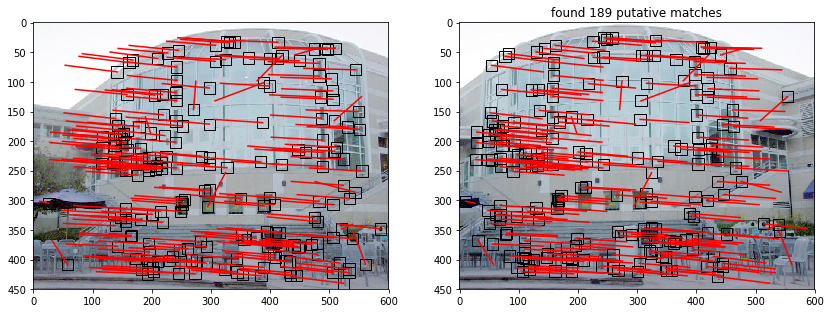

In [44]:
def match(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the proximity threshold
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    # scores is a vector of length k that contains the correlation
    #     coefficients of the matches
    
    """your code here"""
    inds = np.vstack((np.random.choice(pts1.shape[1],200,replace=False), 
                      np.random.choice(pts1.shape[1],200,replace=False)))
    scores = np.random.rand(200)
    
    pts1 = np.vstack((pts1[1], pts1[0]))
    pts2 = np.vstack((pts2[1], pts2[0]))
    
    w_2 = (w - 1) // 2
    m_corr, n_corr = 0, 0
    
    corr_mat = np.zeros((pts1.shape[1], pts2.shape[1])) - 1
    
    
    
    if len(I1.shape)==3:    
        r, g, b = I1[:,:,0], I1[:,:,1], I1[:,:,2]
        I1_bw = 0.2989 * r + 0.5870 * g + 0.1140 * b
    if len(I2.shape)==3:
        r,g,b = I2[:,:,0], I2[:,:,1], I2[:,:,2]
        I2_bw = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    for i in range(pts1.shape[1]):
        i1 = pts1[0,i]
        j1 = pts1[1,i]
        i1 = int(round(i1))
        j1 = int(round(j1))
        
        if (i1-w_2<0) or (i1+w_2+1>I1.shape[0]) or\
        (j1-w_2 < 0) or (j1 + w_2+1>I1.shape[1]):
            m_corr=m_corr+1
            n_corr=0
            continue

        win_temp_bw=I1_bw[i1-w_2:i1+w_2+1,j1-w_2:j1+w_2+1]
        win_mean1_bw=win_temp_bw - np.mean(win_temp_bw)
        #win_sigma1_bw=(np.sum(win_mean1_bw**2))**0.5
        win_sigma1_bw = np.std(win_mean1_bw)
    
        for j in range(pts2.shape[1]):
            i2 = pts2[0, j]
            j2 = pts2[1, j]
            
            i2=int(round(i2))
            j2=int(round(j2))
            
            if i2-w_2<0 or i2+w_2+1>I2.shape[0] or\
            j2-w_2 < 0 or j2 + w_2+1>I2.shape[1]:
                n_corr=n_corr+1
                continue
                
            if np.linalg.norm(np.array(([i1-i2,j1-j2]))) < p:    
                win_temp_bw=I2_bw[i2-w_2:i2+w_2+1,j2-w_2:j2+w_2+1]
                win_mean2_bw= win_temp_bw - np.mean(win_temp_bw)
                win_sigma2_bw=np.std(win_mean2_bw)

                corr_val_bw=np.sum(np.multiply(win_mean1_bw,win_mean2_bw))\
                /(win_sigma1_bw*win_sigma2_bw)
                corr_mat[m_corr][n_corr]=corr_val_bw

            n_corr = n_corr + 1
        m_corr = m_corr + 1
        n_corr = 0
    
    corr_mask = np.ones((corr_mat.shape[0], corr_mat.shape[1]), dtype = np.bool)
    inds = np.zeros((2,1), dtype = int)
    scores = []
    
    for i in range(corr_mask.shape[0]):
        for j in range(corr_mask.shape[1]):
            if corr_mask[i][j] and corr_mat[i][j] > t:
                max_temp = corr_mat[i][j]
                corr_mat[i][j] = -1
                max_next = max(max(corr_mat[i,:]), max(corr_mat[:,j]))
                corr_mat[i][j] = max_temp
                if (1-max_temp) < (1-max_next) * d:
                    
                    
                    #inds = np.row_stack((inds,np.array(([i,j]))))
                    inds = np.hstack((inds, np.array([[i],[j]])))
                    
                    scores.append(corr_mat[i][j])
                    corr_mask[i,:]=False
                    corr_mask[:,j]=False
                    
    inds = np.delete(inds, 0, 1)
    
    return inds, scores

# parameters to tune
w1 = 19
t1 = 0.8
d1 = 1.2
p1 = 89

# do the matching
inds, scores = match(I1, I2, pts1_1, pts2_1, w1, t1, d1, p1)

# create new arays of points which are correspoinding
pts1 = pts1_1[:,inds[0,:]]
pts2 = pts2_1[:,inds[1,:]]

# display the results
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
plt.title('found %d putative matches'%inds.shape[1])
ax2.imshow(I2)
for i in range(inds.shape[1]):
    ii = inds[0,i]
    jj = inds[1,i]
    x1 = pts1_1[0,ii]
    x2 = pts2_1[0,jj]
    y1 = pts1_1[1,ii]
    y2 = pts2_1[1,jj]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))
plt.show()

## Problem 3 (Programing): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error.

hint: this problem has codimension 2

inliers:  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 171, 173, 174, 175, 176, 178, 179, 180, 182, 183, 184, 185, 186, 187]
inlier count:  168
cost_MSAC=373.861483
||H_MSAC||=91.995595
H_MSAC
[[  1.12388366e-02  -3.62031217e-05  -9.82485502e-01]
 [  3.33239527e-04   1.10661853e-02  -1.85374669e-01]
 [  1.30872420e-06   3.93720278e-07   1.04683376e-02]]


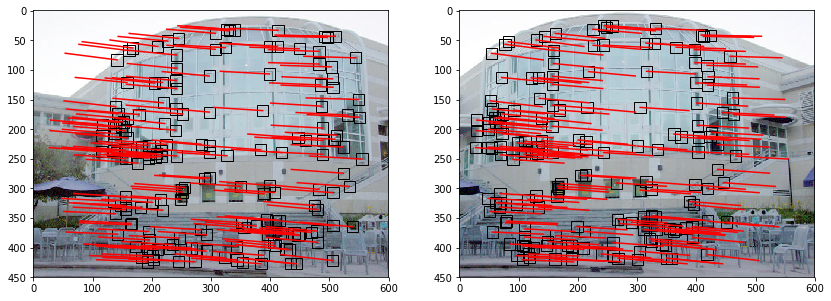

In [69]:
def MSAC(pts1, pts2, max_iters):
    
    import random
    import numpy as np

    def toHomo(x):
        # converts points from inhomogeneous to homogeneous coordinates
        return np.vstack((x,np.ones((1,x.shape[1]))))
    def fromHomo(x):
        # converts points from homogeneous to inhomogeneous coordinates
        return x[:-1,:]/x[-1,:]

    """your code here"""
    def model1(x1, x2):
        
        x1_homo = np.mat(toHomo(x1))
        x2_homo = np.mat(toHomo(x2))
        
        x1_t = x1_homo[:,0:3]
        x2_t = x2_homo[:,0:3]
        
        lambda1 = np.linalg.solve(x1_t, x1_homo[:,3])
        lambda2 = np.linalg.solve(x2_t, x2_homo[:,3])
        
        H1_inv = np.hstack((lambda1[0,0] * x1_t[:,0],\
                            lambda1[1,0] * x1_t[:,1], lambda1[2,0] * x1_t[:,2]))
        H2_inv = np.hstack((lambda2[0,0] * x2_t[:,0],\
                            lambda2[1,0] * x2_t[:,1], lambda2[2,0] * x2_t[:,2]))
        
        H = H2_inv * np.linalg.inv(H1_inv)
        return H
    
    
    def model2(x1, x2, H, tolerance):
        H = np.mat(H)
        h = np.mat(np.reshape(H,(9,1)))
        x1_homo = np.mat(toHomo(x1))
        x2_homo = np.mat(toHomo(x2))
        
        error_correction = []
        
        x1 = np.mat(x1)
        x2 = np.mat(x2)
        
        cost_sampson = 0
        inliers = []
        for i in range(x1.shape[1]):
            x1i = x1_homo[:,i]
            x2i = x2_homo[:,i]
            
            Ai_1 = np.hstack((np.zeros((1,3)), -x1i.T, x2i[1]*x1i.T))
            Ai_2 = np.hstack((x1i.T, np.zeros((1,3)), -x2i[0]*x1i.T))
            
            Ai = np.vstack((Ai_1,Ai_2))
            
            Ai_h = np.mat(Ai) * h
            
            Ji_1 = np.hstack((-H[1,0] + x2i[1,0] * H[2,0],\
                              -H[1,1] + x2i[1,0] * H[2,1],\
                              0,\
                              x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2] ))
            
            Ji_2 = np.hstack(( H[0,0] - x2i[0,0] * H[2,0],\
                               H[0,1] - x2i[0,0] * H[2,1],\
                              -(x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2]),\
                              0))
        
            Ji = np.mat(np.vstack((Ji_1, Ji_2)))
        
            #epsilon = Ai_h
            epsilon = np.vstack((-(x1i[0,0] * H[1,0] + x1i[1,0] * H[1,1] + H[1,2]) + \
                    x2i[1,0] * (x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2]),\
                    x1i[0,0] * H[0,0] + x1i[1,0] * H[0,1] + H[0,2] -\
                    x2i[0,0] * (x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2])))
            #lbd = np.linalg.inv(Ji * Ji.T) * (-epsilon)
            lbd = np.linalg.solve(Ji * Ji.T, -epsilon)
         
            delta = Ji.T * lbd

            errori = np.float(delta.T * delta)
            error_correction.append(errori)

            if errori >= tolerance:
                cost_sampson = cost_sampson + tolerance
            else:
                cost_sampson = cost_sampson + errori
                inliers.append(i)
            
        return error_correction, cost_sampson, inliers
       
    iters = 0
    x_len = pts1.shape[1]
    p = 0.99
    cost = np.inf # MSAC cost
    iters = 0 # number of MSAC itterations executed
    tolerance = 5.9915
    s = 4
    
    
    while (iters <= max_iters) and (cost > 160):
        iters = iters + 1
        ind_rand = random.sample(list(range(x_len)),4)

        x1_sample = pts1[:,ind_rand]
        x2_sample = pts2[:,ind_rand]
        H0 = model1(x1_sample,x2_sample)
        
        err_sam, cost_sam, inliers0 = model2(pts1, pts2, H0, tolerance)
        
        if cost_sam < cost:
            
            H = H0
            cost = cost_sam
            w = len(inliers0) / x_len
            max_iters = np.abs(np.log(1-p) / np.log(1- w**s))
            inliers = inliers0
    H = np.array(H)
    
    return H, inliers, cost, iters

# MSAC hyperparameters (add any additional hyperparameters necessary here. For example p)
# You should pass these hyperparameters as additional paramters to MSAC(...)
max_iters=1

H_MSAC, inliers, cost_MSAC, iters_MSAC = MSAC(pts1, pts2, max_iters)
print('inliers: ', inliers)
print('inlier count: ', len(inliers))

print('cost_MSAC=%f'%cost_MSAC)
print('||H_MSAC||=%f'%np.sqrt(np.sum(H_MSAC**2)))
print('H_MSAC')
print(H_MSAC/np.sqrt(np.sum(H_MSAC**2)))

# display the results
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
for i in range(inds[:,inliers].shape[1]):
    ii = inds[0,inliers[i]]
    jj = inds[1,inliers[i]]
    x1 = pts1_1[0,ii]
    x2 = pts2_1[0,jj]
    y1 = pts1_1[1,ii]
    y2 = pts2_1[1,jj]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))
plt.show()

## Problem 4 (Programing): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution.  Include the numerical values of the resulting
  $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [70]:
def DLT(pts1, pts2):
    """your code here"""
    def toHomo(x):
        # converts points from inhomogeneous to homogeneous coordinates
        return np.vstack((x,np.ones((1,x.shape[1]))))
    def fromHomo(x):
        # converts points from homogeneous to inhomogeneous coordinates
        return x[:-1,:]/x[-1,:]
    def model2(x1, x2, H):
        H = np.mat(H)
        h = np.mat(np.reshape(H,(9,1)))
        x1_homo = np.mat(toHomo(x1))
        x2_homo = np.mat(toHomo(x2))
        
        x1_correction = np.mat(np.zeros((2, x1.shape[1])))
        x2_correction = np.mat(np.zeros((2, x2.shape[1])))
        
        error_correction = []
        
        x1 = np.mat(x1)
        x2 = np.mat(x2)
        
        cost_sampson = 0
        inliers = []
        for i in range(x1.shape[1]):
            x1i = x1_homo[:,i]
            x2i = x2_homo[:,i]
            
            Ai_1 = np.hstack((np.zeros((1,3)), -x1i.T, x2i[1]*x1i.T))
            Ai_2 = np.hstack((x1i.T, np.zeros((1,3)), -x2i[0]*x1i.T))
            Ai = np.vstack((Ai_1,Ai_2))
            
            Ai_h = np.mat(Ai) * h
            
            Ji_1 = np.hstack((-H[1,0] + x2i[1,0] * H[2,0],\
                              -H[1,1] + x2i[1,0] * H[2,1],\
                              0,\
                              x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2] ))
            
            Ji_2 = np.hstack(( H[0,0] - x2i[0,0] * H[2,0],\
                               H[0,1] - x2i[0,0] * H[2,1],\
                              -(x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2]),\
                              0))
        
            Ji = np.mat(np.vstack((Ji_1,Ji_2)))
            #epsilon = Ai_h
            
            epsilon = np.vstack((-(x1i[0,0] * H[1,0] + x1i[1,0] * H[1,1] + H[1,2]) + \
                    x2i[1,0] * (x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2]),\
                    x1i[0,0] * H[0,0] + x1i[1,0] * H[0,1] + H[0,2] -\
                    x2i[0,0] * (x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2])))
            
            lbd = np.linalg.inv(Ji * Ji.T) * (-epsilon)
            lbd = np.linalg.solve(Ji * Ji.T, -epsilon)
         
            delta = Ji.T * lbd
            
            x1_correction[:,i] = x1[:,i] + delta[0:2,0]
            x2_correction[:,i] = x2[:,i] + delta[2:4,0]
            
            cost_sampson += np.float(delta.T * delta)
            
        return x1_correction, cost_sampson
    
    def norm_func(x_input):
        mean_x = np.mean(x_input,1)
        var_x = np.var(x_input,1)
        sigma_x = np.sum(var_x)
        s_x = np.sqrt(x_input.shape[0] / sigma_x)
        T_x = np.mat(np.vstack(([s_x, 0, -s_x * mean_x[0,0]],\
                                [0, s_x, -s_x * mean_x[1,0]],\
                                [0, 0, 1])) )

        return T_x
    """your code here"""

    tolerance = 5.9915
    cost = np.inf # linear cost
    pts1 = np.mat(pts1)
    pts2 = np.mat(pts2)
    
    mean_pts1 = np.mean(pts1,1)
    mean_pts2 = np.mean(pts2,1)
    
    var_pts1 = np.var(pts1,1)
    var_pts2 = np.var(pts2,1)
    
    sigma2_pts1 = np.sum(var_pts1)
    sigma2_pts2 = np.sum(var_pts2)
    
    s_pts1 = np.sqrt(2 / sigma2_pts1)
    s_pts2 = np.sqrt(2 / sigma2_pts2)
    
    T_pts1 = np.vstack(([s_pts1, 0, -s_pts1 * mean_pts1[0,0]],\
                        [0, s_pts1, -s_pts1 * mean_pts1[1,0]],\
                        [0, 0, 1]))
    
    T_pts2 = np.vstack(([s_pts2, 0, -s_pts2 * mean_pts2[0,0]],\
                        [0, s_pts2, -s_pts2 * mean_pts2[1,0]],\
                        [0, 0, 1]))
    
    pts1_norm = T_pts1 * toHomo(pts1)
    pts2_norm = T_pts2 * toHomo(pts2)
    A = np.array(np.zeros((1,9)))
    e1 = np.mat([1,0,0]).T
    
    
    for i in range(pts1_norm.shape[1]):
        pts2i = pts2_norm[:,i]
        pts1i = pts1_norm[:,i]
        v = pts2i + np.sign(pts2i[0,0]) * np.linalg.norm(pts2i) * e1
        Hv = np.eye(3) - 2 * v * v.T / (v.T * v)
        
        pts_per = Hv[1:,:]
        A_i1 = np.hstack((pts_per[0, 0] * pts1i.T,\
                          pts_per[0, 1] * pts1i.T,\
                          pts_per[0, 2] * pts1i.T))
        
        A_i2 = np.hstack((pts_per[1, 0] * pts1i.T,\
                          pts_per[1, 1] * pts1i.T,\
                          pts_per[1, 2] * pts1i.T))
        
        A_i = np.vstack((A_i1, A_i2))
        A = np.vstack((A,A_i))
    A = np.delete(A,0,0)
    
    U,S,Vt = np.linalg.svd(A)
    V = Vt.T
    H_tilt = V[:,-1].reshape(3,3)
    H = np.linalg.inv(T_pts2) * H_tilt * T_pts1
    
    T_x1 = norm_func(pts1)
    T_x2 = norm_func(pts2)
    pts1_norm = T_x1 * toHomo(pts1)
    pts2_norm = T_x2 * toHomo(pts2)
    H_norm = T_x2 * H * np.linalg.inv(T_x1)
    
    sigma1 = T_x1[0:2,0:2] * T_x1[0:2,0:2]
    sigma2 = T_x2[0:2,0:2] * T_x2[0:2,0:2]
    
    xs, cost_notused = model2(fromHomo(pts1_norm), fromHomo(pts2_norm), H_norm)
    
    diff1 = fromHomo(pts1_norm) - fromHomo(np.eye(3) * toHomo(xs))
    diff2 = fromHomo(pts2_norm) - fromHomo(H_norm * toHomo(xs))
    
    cost = np.trace(diff1.T * np.linalg.inv(sigma1) * diff1)\
    + np.trace(diff2.T * np.linalg.inv(sigma2) * diff2)
    
    H = np.array(H)
    return H, cost


H_DLT, cost_DLT = DLT(pts1[:,inliers], pts2[:,inliers])
print('cost_DLT=%f'%cost_DLT)
print('||H_DLT||=%f'%np.sqrt(np.sum(H_DLT**2)))
print('H_DLT')
print(H_DLT/np.sqrt(np.sum(H_DLT**2)))

cost_DLT=70.627308
||H_DLT||=53.895061
H_DLT
[[  1.10269444e-02  -3.44655012e-05  -9.83284244e-01]
 [  3.33809452e-04   1.07394737e-02  -1.81134018e-01]
 [  1.28224401e-06   7.32855659e-08   1.02722988e-02]]


## Problem 5 (Programing): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors (see section A6.9.2 (page 624) of the textbook, and the corrections and errata).
  Show the numerical values for the final estimate of the planar projective
  transformation matrix $\boldsymbol{H}_\text{LM}$, scaled such that
  $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [77]:
# feel free to modify the function signature as needed (pass parameterized H instead of homogeneous matrix, etc...)
def LMstep(H, pts1, pts2, l, v):
    
    def toHomo(x):
        # converts points from inhomogeneous to homogeneous coordinates
        return np.vstack((x,np.ones((1,x.shape[1]))))
    
    def fromHomo(x):
        # converts points from homogeneous to inhomogeneous coordinates
        return x[:-1,:]/x[-1,:]
   
    def dsinc_dx(x_input):
        val = np.cos(x_input) / x_input - np.sin(x_input)\
        / (x_input * x_input)
        return val
    
    def Para_fun(x_input):
        assert x_input.shape[0] > 2
        x_input = x_input / np.linalg.norm(x_input)
        pi = np.pi
        a_x = x_input[0,0]
        b_x = x_input[1:,0]

        x_hat = 2 * b_x / (np.sinc(np.arccos(a_x) / pi))
        x_hat_norm = np.linalg.norm(x_hat)

        if x_hat_norm > pi:
            x_hat = (1 - (2 * pi / x_hat_norm) *\
                 np.ceil((x_hat_norm - pi) / (2 * pi) )) * x_hat
            x_hat_norm = np.linalg.norm(x_hat)

        x_hat_norm_2 = x_hat_norm / 2

        if x_hat_norm == 0:
            da_dx = np.zeros((1,b_x.shape[0]))
            db_dx = 0.5 * np.eye(b_x.shape[0])

        else:
            da_dx = -0.5 * b_x.T
            db_dx = 0.5 * np.sinc(x_hat_norm_2 / pi) * np.eye(b_x.shape[0]) + \
                    1 / (4 * x_hat_norm) * dsinc_dx(x_hat_norm_2) * \
                    x_hat * x_hat.T

        dx_dx = np.vstack((da_dx, db_dx))

        return dx_dx, x_hat    
    
    def fromPara(x_input):
        pi = np.pi
        x_input_norm = np.linalg.norm(x_input)
        if x_input_norm > pi:
            x_input = (1 - 2 * pi / x_input_norm *\
                 np.ceil((x_input_norm - pi) / (2 * pi) )) * x_input
            x_input_norm = np.linalg.norm(x_input)
        x_input_norm_2 = x_input_norm / 2
        
        a = np.cos(x_input_norm_2)
        b = np.sinc(x_input_norm_2 / np.pi) * x_input /2
        
        x_out = np.vstack((a, b))
        return x_out
    
    def model2(x1, x2, H):
        H = np.mat(H)
        h = np.mat(np.reshape(H,(9,1)))
        x1_homo = np.mat(toHomo(x1))
        x2_homo = np.mat(toHomo(x2))
        
        x1_correction = np.mat(np.zeros((2, x1.shape[1])))
        x2_correction = np.mat(np.zeros((2, x2.shape[1])))
        
        error_correction = []
        
        x1 = np.mat(x1)
        x2 = np.mat(x2)
        
        cost_sampson = 0
        inliers = []
        for i in range(x1.shape[1]):
            x1i = x1_homo[:,i]
            x2i = x2_homo[:,i]
            
            Ai_1 = np.hstack((np.zeros((1,3)), -x1i.T, x2i[1]*x1i.T))
            Ai_2 = np.hstack((x1i.T, np.zeros((1,3)), -x2i[0]*x1i.T))
            Ai = np.vstack((Ai_1,Ai_2))
            
            Ai_h = np.mat(Ai) * h
            
            Ji_1 = np.hstack((-H[1,0] + x2i[1,0] * H[2,0],\
                              -H[1,1] + x2i[1,0] * H[2,1],\
                              0,\
                              x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2] ))
            
            Ji_2 = np.hstack(( H[0,0] - x2i[0,0] * H[2,0],\
                               H[0,1] - x2i[0,0] * H[2,1],\
                              -(x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2]),\
                              0))
        
            Ji = np.mat(np.vstack((Ji_1,Ji_2)))
            #epsilon = Ai_h
            
            epsilon = np.vstack((-(x1i[0,0] * H[1,0] + x1i[1,0] * H[1,1] + H[1,2]) + \
                    x2i[1,0] * (x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2]),\
                    x1i[0,0] * H[0,0] + x1i[1,0] * H[0,1] + H[0,2] -\
                    x2i[0,0] * (x1i[0,0] * H[2,0] + x1i[1,0] * H[2,1] + H[2,2])))
            
            #lbd = np.linalg.inv(Ji * Ji.T) * (-epsilon)
            lbd = np.linalg.solve(Ji * Ji.T, -epsilon)
         
            delta = Ji.T * lbd
            
            x1_correction[:,i] = x1[:,i] + delta[0:2,0]
            x2_correction[:,i] = x2[:,i] + delta[2:4,0]
            
            cost_sampson += np.float(delta.T * delta)
            
        return x1_correction, cost_sampson
    
    def norm_func(x_input):
        mean_x = np.mean(x_input,1)
        var_x = np.var(x_input,1)
        sigma_x = np.sum(var_x)
        s_x = np.sqrt(x_input.shape[0] / sigma_x)
        T_x = np.mat([[s_x, 0, -s_x * mean_x[0,0]],\
                      [0, s_x, -s_x * mean_x[1,0]],\
                      [0, 0, 1]])

        return T_x
    
            
    """your code here"""
    
    pts1 = np.mat(pts1)
    pts2 = np.mat(pts2)
    
    pi = np.pi
    cost = np.inf
    data_len = pts1.shape[1]
    Sigma0 = np.eye(2)


    # DN part ---------------------------------------------------------

    T_pts1 = norm_func(pts1)
    T_pts2 = norm_func(pts2)

    
    pts1_norm = np.mat(T_pts1 * toHomo(pts1))
    pts2_norm = np.mat(T_pts2 * toHomo(pts2))
    #xs_norm = np.mat(T_s * toHomo(xs))
    
    sigma1_norm = T_pts1[0:2,0:2].T * Sigma0 * T_pts1[0:2,0:2]
    sigma2_norm = T_pts2[0:2,0:2].T * Sigma0 * T_pts2[0:2,0:2]
    
    H = np.mat(H / np.linalg.norm(H))
    
    H_norm = T_pts2 * H * np.linalg.inv(T_pts1)
    H_norm = H_norm / np.linalg.norm(H_norm)
    
    pts1_corr,cost_notused = model2(fromHomo(pts1_norm),\
                                    fromHomo(pts2_norm), H_norm)
    
    H1_norm = np.eye(3)
    H2_norm = H_norm
    
    
    xs_norm = H1_norm * toHomo(pts1_corr)
    
    #  H2_para --------------------------------------------------------------
    
    h_inp = np.reshape(H2_norm, (9, 1))
    dh_dh, h_hat = Para_fun(h_inp)
    
    # ---------------------------------------------------------
    
    U = np.zeros((8,8))
    wi_save = np.zeros((8,1))
    V_save = np.zeros((4,1))
    eps_a = np.zeros((8,1))
    S_p2 = np.zeros((8,8))
    e_p2 = np.zeros((8,1))
    eps_bi_save = np.zeros((2,1))
    xsi_hat_save = np.zeros((2,1))
    
    for i in range(data_len):
        
        x1i = pts1_norm[:,i]
        x2i = pts2_norm[:,i]
        xsi = xs_norm[:,i]
        
        # For Ai prime-----------------------------------------------
        
        w_ai = float(H2_norm[2,:] * xsi)
        
        dx_dh1 = np.hstack(([xsi.T, np.zeros((1,3)), -x2i[0,0] * xsi.T]))
        dx_dh2 = np.hstack(([np.zeros((1,3)), xsi.T, -x2i[1,0] * xsi.T]))
        
        dx_dh = np.vstack((dx_dh1, dx_dh2)) / w_ai
        Ai = dx_dh * dh_dh
        
        # For Bi -----------------------------------------------
    
        w_bi1 = float(H1_norm[2,:] * xsi)
        dx_dx_bar1 = np.vstack((H1_norm[0,:] - x1i[0,0] * H1_norm[2,:] , \
                                H1_norm[1,:] - x1i[1,0] * H1_norm[2,:])) / w_bi1

        dx_bar_dx1, xsi_hat= Para_fun(xsi)
        B1i =  dx_dx_bar1 * dx_bar_dx1
        '''print('Bi_1',dx_dx_bar1)
        print('Bi_2',dx_bar_dx1)
        print('Bi',B1i)'''
        # For Bi prime-----------------------------------------------
    
        w_bi2 = float(H2_norm[2,:] * xsi)
        dx_dx_bar2 = np.vstack((H2_norm[0,:] - x2i[0,0] * H2_norm[2,:] , \
                                H2_norm[1,:] - x2i[1,0] * H2_norm[2,:])) / w_bi2
    
        dx_bar_dx2, xsi_hat = Para_fun(xsi)
        B2i =  dx_dx_bar2 * dx_bar_dx2
        
        xsi_hat_save = np.hstack((xsi_hat_save, xsi_hat))
        
        # For UVS -----------------------------------------------------
        
        U = U + Ai.T * np.linalg.inv(sigma2_norm) * Ai
        V =  B1i.T * np.linalg.inv(sigma1_norm) * B1i +\
        B2i.T * np.linalg.inv(sigma2_norm) * B2i
        V_save = np.hstack((V_save, V.reshape(4,1)))
        wi = Ai.T * np.linalg.inv(sigma2_norm) * B2i
        wi_save = np.hstack((wi_save, wi))
        
        eps1i = fromHomo(x1i) - fromHomo(H1_norm * xsi)
        eps2i = fromHomo(x2i) - fromHomo(H2_norm * xsi)

        eps_a = eps_a + Ai.T * np.linalg.inv(sigma2_norm) * eps2i
        eps_bi = B1i.T * np.linalg.inv(sigma1_norm) * eps1i +\
        B2i.T * np.linalg.inv(sigma2_norm) * eps2i
        
        eps_bi_save = np.hstack((eps_bi_save, eps_bi))
        
    wi_save = np.delete(wi_save, 0, 1)
    V_save = np.delete(V_save, 0, 1)
    eps_bi_save = np.delete(eps_bi_save, 0, 1)
    xsi_hat_save = np.delete(xsi_hat_save, 0, 1)
    
    
    '''
    print(wi_save.shape)
    print(V_save.shape)
    print(eps_bi_save.shape)
    print(xsi_hat_save.shape)
    '''
    
    # ------------------------------------------------------ While true
    
    diff_1 = fromHomo(pts1_norm) - fromHomo(H1_norm * xs_norm)
    diff_2 = fromHomo(pts2_norm) - fromHomo(H2_norm * xs_norm)
    error = np.trace(diff_1.T * np.linalg.inv(sigma1_norm) * diff_1) + \
            np.trace(diff_2.T * np.linalg.inv(sigma2_norm) * diff_2)
    cost = error
    iter0 = 0
    while True:
        U_star = U + l * np.eye(U.shape[0])
        S_p2 = np.zeros((8,8))
        e_p2 = np.zeros((8,1))
        for i in range(V_save.shape[1]):
            vi = V_save[:,i].reshape(2,2) + l * np.eye(2)
            wi = wi_save[:,2*i:2*(i+1)]
            epsbi = eps_bi_save[:,i]
            
            S_p2 = S_p2 + wi * np.linalg.inv(vi) * wi.T
            e_p2 = e_p2 + wi * np.linalg.inv(vi) * epsbi
        S = U_star - S_p2
        e_a = eps_a - e_p2
        
        delta_a = np.linalg.solve(S,e_a)
        
        delta_b = np.zeros((2,1))
        for i in range(V_save.shape[1]):
            vi = V_save[:,i].reshape(2,2) + l * np.eye(2)
            wi = wi_save[:,2*i:2*(i+1)]
            epsbi = eps_bi_save[:,i]
            
            delta_b = np.hstack((delta_b, np.linalg.inv(vi) *\
                                 (epsbi - wi.T * delta_a)))
        delta_b = np.delete(delta_b, 0, 1)

        xs_t = xsi_hat_save + delta_b
        
        h0 = h_hat + delta_a
        
        H0 = fromPara(h0)
        H0 = H0.reshape(3,3) / np.linalg.norm(H0)
        
        xs0 = np.zeros((3,1))
        for i in range(xs_t.shape[1]):
            xs0i = fromPara(xs_t[:,i])
            xs0 = np.hstack((xs0, xs0i))
        xs0 = np.delete(xs0, 0, 1)
        xs1 = fromHomo(xs_norm) + delta_b
        # --------------------------------------------------- need thinking
        diff0_1 = fromHomo(pts1_norm) - fromHomo(H1_norm * xs0)
        diff0_2 = fromHomo(pts2_norm) - fromHomo(H0 * xs0)
        '''
        diff0_1 = fromHomo(pts1_norm) - fromHomo(H1_norm * toHomo(xs1))
        diff0_2 = fromHomo(pts2_norm) - fromHomo(H0 * toHomo(xs1))
        '''
        error0 = np.trace(diff0_1.T * np.linalg.inv(sigma1_norm) * diff0_1) + \
                 np.trace(diff0_2.T * np.linalg.inv(sigma2_norm) * diff0_2)
        #print('error',error,error0)
        
        if error0 <= error:
            H = np.linalg.inv(T_pts2) * H0 * T_pts1 
            H = np.array(H / np.linalg.norm(H))

            #H = H0
            cost = error0
            l = l / v
            break
            
        else:
            l = l * v
            iter0 += 1
            if iter0 > 50:
                break
        
    return H, cost, l


# LM hyperparameters
l=.001
v=10
max_iters=10

H_LM = H_DLT
# LM optimization loop

print('iter %d cost %f'%(0, cost_DLT))
for i in range(max_iters):
    H_LM, cost_LM, l = LMstep(H_LM, pts1[:,inliers], pts2[:,inliers], l, v)
    print ('iter %d cost %f'%(i+1, cost_LM))

print('||H_LM||=%f'%np.sqrt(np.sum(H_LM**2)))
print('H_LM')
print(H_LM/np.sqrt(np.sum(H_LM**2)))

iter 0 cost 70.627308
iter 1 cost 70.481500
iter 2 cost 70.374084
iter 3 cost 70.346301
iter 4 cost 70.338958
iter 5 cost 70.336954
iter 6 cost 70.336380
iter 7 cost 70.336204
iter 8 cost 70.336108
iter 9 cost 70.336104
iter 10 cost 70.336100
||H_LM||=1.000000
H_LM
[[  1.10269184e-02  -3.32024593e-05  -9.83552022e-01]
 [  3.32909950e-04   1.07355939e-02  -1.79674280e-01]
 [  1.27278179e-06   7.02572059e-08   1.02769492e-02]]
